# 3D U-Net on BraTS glioma dataset

In [ ]:
%reload_ext rpy2.ipython

import os
import argparse
import datetime
import numpy as np
from tqdm import tqdm

import mxnet as mx
from mxnet import gluon, autograd, ndarray as nd
from mxnet.gluon.utils import split_and_load

from unet_brats.unet import *

***
## Setup hyperparameters

In [ ]:
args = argparse.Namespace()

args.data_dir = '/datasets/brats_2018' # Should contain 'training' and 'validation' dirs. 
args.fold = 0 # Fold for 10-fold CV on training data. Comment out to include all data.

# Training
args.resume = ''
args.start_epoch = 0
args.epochs = 600
args.batch_size = 6
args.num_workers = 6
# args.smooth = 1
args.optimizer = 'adam'
args.optimizer_params = {'learning_rate': 0.0001}
# GPU_COUNT = 1
# args.ctx = [mx.gpu(i) for i in range(GPU_COUNT)]
args.ctx = [mx.gpu(0)]

# Unet
args.num_downs = 4 # Number of encoding/downsampling layers
args.classes = 4 # Number of classes for segmentation, including background
args.ngf = 32 # Number of channels in base/outermost layer
args.use_bias = True # For conv blocks
args.use_global_stats = True # For BN blocks

# Pre/post-processing
args.crop_size_train = [80, 80, 80] # Training patch size
args.pad_size_val = [240, 240, 155] # Should be input vol dims unless 'crop_size_val' is larger
args.crop_size_val = [192, 192, 144] # Should be divisible by 2^num_downs
args.overlap = 0 # Fractional overlap for val patch prediction, combined with voting
if hasattr(args, 'fold'): 
    args.fold_inds = get_k_folds(n=285, k=10, seed=1)[args.fold]
args.lesion_frac = 0.9 # Fraction of patch centerpoints to be placed within lesion (vs randomly within brain)
# args.warp_params = None
args.warp_params = {'theta_max': 45,
                    'offset_max': 0,
                    'scale_max': 1.25,
                    'shear_max': 0.1}

# Checkpoint
args.save_interval = args.epochs
args.save_dir = '../params/baseline'
args.val_interval = 10
fold_str = 'fold' + str(args.fold) if hasattr(args, 'fold') else 'foldAll'
time_str = str(datetime.datetime.now().strftime("%Y-%m-%dT%H%M%S"))
net_name = '_'.join(('unet', str(args.crop_size_train[0]), fold_str, time_str))
args.save_prefix = os.path.join(args.save_dir, net_name, net_name)

***
## Setup data loaders

In [ ]:
data = np.load('../data/normalization_stats.npz')
means       = nd.array(data['means'])
stds        = nd.array(data['stds'])
means_brain = nd.array(data['means_brain'])
stds_brain  = nd.array(data['stds_brain'])

In [ ]:
trainset = MRISegDataset(root=args.data_dir, split='train', mode='train', crop_size=args.crop_size_train, transform=brats_transform, means=means_brain, stds=stds_brain, fold_inds=args.fold_inds, lesion_frac=args.lesion_frac, warp_params=args.warp_params)
valset   = MRISegDataset(root=args.data_dir, split='val',   mode='val',   crop_size=args.pad_size_val,    transform=brats_transform, means=means_brain, stds=stds_brain, fold_inds=args.fold_inds)

train_data = gluon.data.DataLoader(trainset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True,  last_batch='rollover')
val_data   = gluon.data.DataLoader(valset,   batch_size=1,               num_workers=args.num_workers, shuffle=False, last_batch='keep')

***
## Display example training patch

In [ ]:
img, mask = trainset[0]
img = img[3].asnumpy()
mask = mask.squeeze().asnumpy()
print('Training patch size:')
img.shape

In [ ]:
%%R -i img -i mask -w 800 -h 300 -u px

library(neurobase)
ortho2(img, mfrow=c(1,3))
ortho2(img, mask, col.y=rainbow(3), zlim.y=c(1,3), mfrow=c(1,3))

***
## Setup model

In [ ]:
model = UnetGenerator(num_downs        = args.num_downs, 
                      classes          = args.classes, 
                      ngf              = args.ngf, 
                      use_bias         = args.use_bias, 
                      use_global_stats = args.use_global_stats)

In [ ]:
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(), force_reinit=True, ctx=args.ctx)
if args.resume.strip():
    model.load_parameters(os.path.join('../params', args.resume.strip()))

***
## Train

In [ ]:
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)

In [ ]:
trainer = gluon.Trainer(model.collect_params(), args.optimizer, args.optimizer_params)

In [ ]:
logger, sw = start_logger(args)

best_wt     = 0.
best_avg    = 0.
global_step = 0
for epoch in range(args.start_epoch, args.epochs):
    tbar = tqdm(train_data)
    train_loss = 0.
    for i, (data, label) in enumerate(tbar):
        n_batch = data.shape[0]
        label = label.squeeze(axis=1)
        label = split_and_load(label, args.ctx)
        data  = split_and_load(data,  args.ctx)
        with autograd.record():
            losses = [loss(model(X), Y) for X, Y in zip(data, label)]
            for l in losses:
                l.backward()
                train_loss += l.sum().asnumpy() / n_batch
        trainer.step(n_batch)

        # Mini-batch logging
        sw.add_scalar(tag='Cross_Entropy', value=('Train loss', l.mean().asscalar()), global_step=global_step)
        global_step += 1
        if i < (len(tbar) - 1):
            tbar.set_description('E %d | loss %.4f'%(epoch, train_loss/(i+1)))
    
    # Epoch logging
    if (epoch + 1) % args.val_interval == 0:
        mx.nd.waitall()
        metrics = brats_validate(model, val_data, crop_size=args.crop_size_val, overlap=args.overlap, ctx=args.ctx[0])
        DSC_avg = log_epoch_hooks(epoch, train_loss/(i+1), metrics, logger, sw)
        best_wt  = save_params(model, best_wt, metrics['WT']['DSC'], epoch, args.save_interval, args.save_prefix)
        best_avg = save_params(model, best_avg, DSC_avg, epoch, None, args.save_prefix + '_avg')
sw.export_scalars(args.save_prefix + '_scalar_dict.json')
sw.close()

***
## Load best model parameters

In [ ]:
model.load_parameters(args.save_prefix + "_avg_best.params")

***
## Test inference on example hold-out validation subject

In [ ]:
idx=1
data, mask = valset[idx]

output_mask = brats_predict(model, data.expand_dims(axis=0), crop_size=args.crop_size_val, overlap=args.overlap, n_classes=4, ctx=args.ctx[0])

mask = mask.squeeze().asnumpy()
data = data.squeeze().asnumpy()

metrics = calc_brats_metrics(mask, output_mask)
dices = [metric['DSC'] for _, metric in metrics.items()]

print('Data path: ' + valset.paths()[idx])

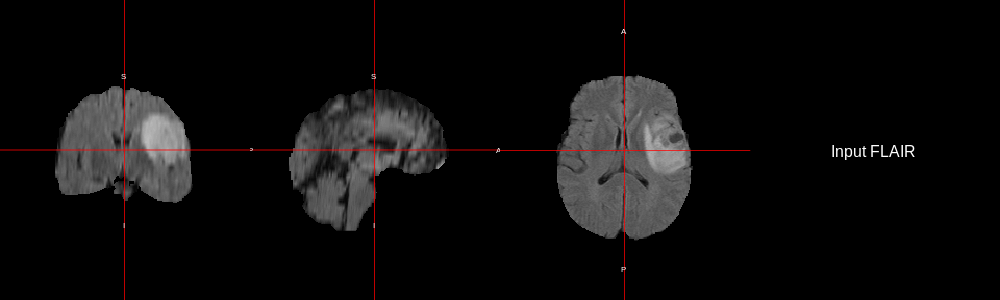

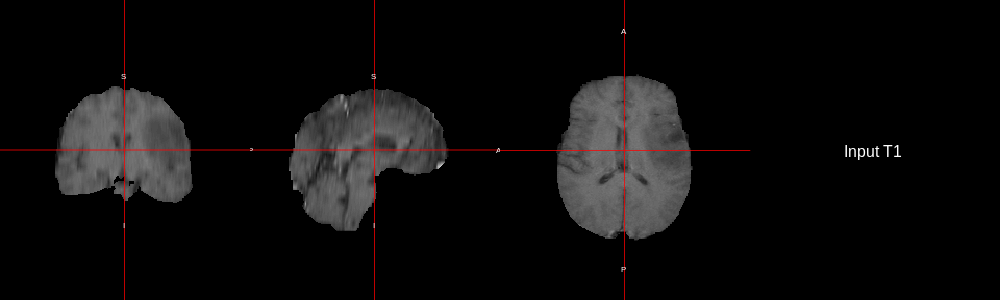

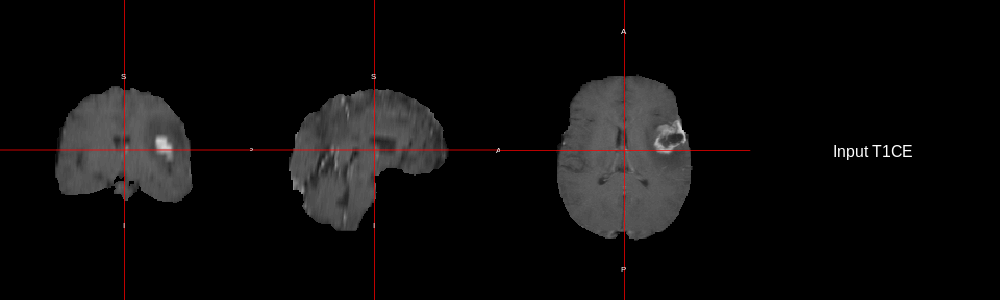

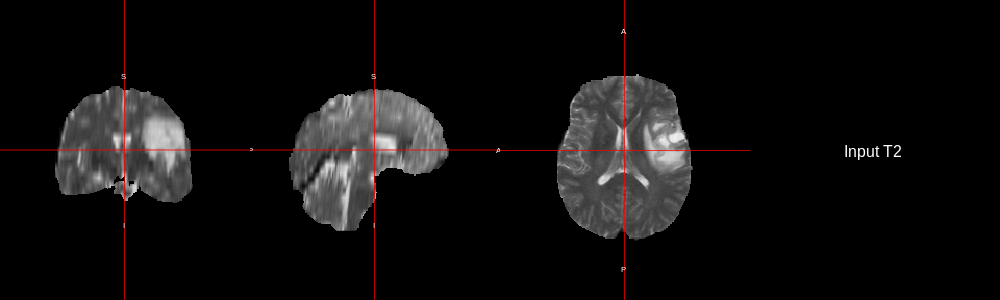

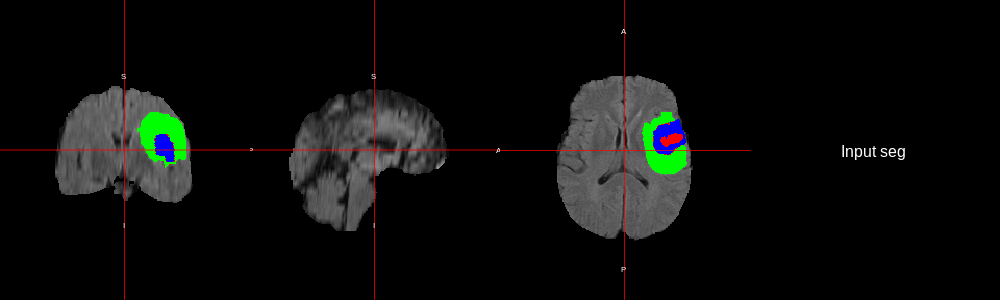

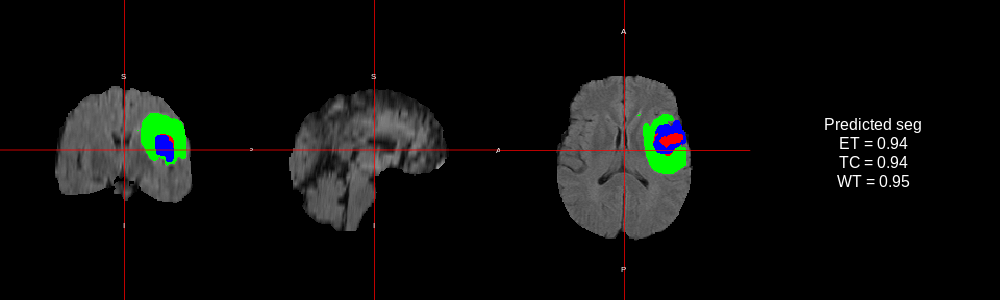

In [ ]:
%%R -i data -i mask -i output_mask -i dices -w 1000 -h 300 -u px

library(neurobase)

ortho2(data[1,,,], mfrow=c(1,4), text='Input FLAIR')
ortho2(data[2,,,], mfrow=c(1,4), text='Input T1')
ortho2(data[3,,,], mfrow=c(1,4), text='Input T1CE')
ortho2(data[4,,,], mfrow=c(1,4), text='Input T2')
ortho2(data[1,,,], mask,        col.y=rainbow(3), zlim.y=c(1,3), mfrow=c(1,4), text='Input seg')
ortho2(data[1,,,], output_mask, col.y=rainbow(3), zlim.y=c(1,3), mfrow=c(1,4), text=sprintf('Predicted seg\nET = %.2f\nTC = %.2f\nWT = %.2f', dices[1], dices[2], dices[3]), NA.y=FALSE)